# Data Pre Processing


### Phase A — Notebook-driven dataset understanding (choose parameters first)

#### Build a dataset manifest (index)

In [1]:
from pathlib import Path
import pandas as pd

# Paths
project_root = Path.home() / "fyp-musicgen"
raw_root = project_root / "data" / "raw" / "lmd_full"
out_csv = project_root / "data" / "processed" / "manifests" / "lmd_full_manifest.csv"

# Collect MIDI files
midi_files = []
for ext in ("*.mid", "*.midi", "*.MID", "*.MIDI"):
    midi_files.extend(raw_root.rglob(ext))

rows = []
for p in midi_files:
    rel = p.relative_to(raw_root).as_posix()        # e.g., "a/abc123.mid"
    prefix = rel.split("/", 1)[0]                   # "a", "0", ...
    size_bytes = p.stat().st_size
    rows.append({"path": rel, "size_bytes": size_bytes, "folder_prefix": prefix})

df = pd.DataFrame(rows).sort_values(["folder_prefix", "path"]).reset_index(drop=True)

print("Total MIDI files found:", len(df))
print(df.head())

df.to_csv(out_csv, index=False)
print("Saved manifest to:", out_csv)


Total MIDI files found: 178561
                                     path  size_bytes folder_prefix
0  0/00000ec8a66b6bd2ef809b0443eeae41.mid         870             0
1  0/0000799e8672292fe6f0fff08554ca40.mid       15277             0
2  0/00012722c199ae2a628ebb792ccc617a.mid        7709             0
3  0/000203a04a64ad57329a058f11e235cb.mid       33136             0
4  0/00032fb2047d3cdd0394b89349d858b4.mid       31556             0
Saved manifest to: /home/e20fyptemp1/fyp-musicgen/data/processed/manifests/lmd_full_manifest.csv


#### Quick sanity checks

In [2]:
import pandas as pd
from pathlib import Path

manifest = Path.home() / "fyp-musicgen" / "data" / "processed" / "manifests" / "lmd_full_manifest.csv"
df = pd.read_csv(manifest)

print(df["folder_prefix"].value_counts().sort_index())
print("Min size:", df["size_bytes"].min(), "bytes")
print("Max size:", df["size_bytes"].max(), "bytes")


0    11132
1    11102
2    11139
3    11056
4    11136
5    11262
6    11249
7    11258
8    11097
9    11107
a    11137
b    11214
c    11167
d    11200
e    11076
f    11229
Name: folder_prefix, dtype: int64
Min size: 0 bytes
Max size: 3888274 bytes


The “Min size: 0 bytes” is a red flag
For inference/training, 0-byte files will crash loaders (rasterio/GDAL will fail)

In [3]:
(df.size_bytes==0).sum()

1

removing 0 byte file from dataframe.

In [6]:
from pathlib import Path
import pandas as pd

project_root = Path.home() / "fyp-musicgen"
in_path = project_root / "data" / "processed" / "manifests" / "lmd_full_manifest.csv"
out_path = project_root / "data" / "processed" / "manifests" / "lmd_full_manifest_clean.csv"

df = pd.read_csv(in_path)
df = df[df["size_bytes"] > 0].copy()
df.to_csv(out_path, index=False)

print("Saved clean manifest to:", out_path)
print("Rows:", len(df))


Saved clean manifest to: /home/e20fyptemp1/fyp-musicgen/data/processed/manifests/lmd_full_manifest_clean.csv
Rows: 178560


#### Load manifest + create a deterministic stratified sample

In [7]:
from pathlib import Path
import pandas as pd

project_root = Path.home() / "fyp-musicgen"
manifest_path = project_root / "data" / "processed" / "manifests" / "lmd_full_manifest.csv"
df = pd.read_csv(manifest_path)

# drop the single empty file (and any extremely tiny files if you want)
df = df[df["size_bytes"] > 0].copy()

# stratified sample: same count from each prefix
SAMPLE_PER_PREFIX = 300  # total = 16 * 300 = 4800
sample_df = (
    df.groupby("folder_prefix", group_keys=False)
      .apply(lambda g: g.sample(n=min(SAMPLE_PER_PREFIX, len(g)), random_state=42))  #take a random sample from group
      .reset_index(drop=True)  #reset row index
)

print("Sample size:", len(sample_df))
sample_df["folder_prefix"].value_counts().sort_index()


Sample size: 4800


0    300
1    300
2    300
3    300
4    300
5    300
6    300
7    300
8    300
9    300
a    300
b    300
c    300
d    300
e    300
f    300
Name: folder_prefix, dtype: int64

#### Parse + log failures (miditoolkit)

In [8]:
import time
import traceback
from miditoolkit import MidiFile

raw_root = project_root / "data" / "raw" / "lmd_full"

rows = []
t0 = time.time()

for i, r in sample_df.iterrows():
    rel_path = r["path"]
    full_path = raw_root / rel_path
    size_bytes = int(r["size_bytes"])
    prefix = r["folder_prefix"]

    status = "ok"
    err_type = ""
    err_msg = ""

    n_notes = None
    n_instruments = None
    n_tempo = None
    n_ts = None

    try:
        midi = MidiFile(str(full_path))
        # basic counts
        n_instruments = len(midi.instruments)
        n_notes = sum(len(ins.notes) for ins in midi.instruments)
        n_tempo = len(midi.tempo_changes) if midi.tempo_changes is not None else 0
        n_ts = len(midi.time_signature_changes) if midi.time_signature_changes is not None else 0

        # treat "parsed but no notes" as a failure category (useful later)
        if n_notes == 0:
            status = "blank_no_notes"

    except Exception as e:
        status = "fail"
        err_type = type(e).__name__
        err_msg = str(e)[:300]  # keep it short

    rows.append({
        "path": rel_path,
        "folder_prefix": prefix,
        "size_bytes": size_bytes,
        "status": status,
        "err_type": err_type,
        "err_msg": err_msg,
        "n_instruments": n_instruments,
        "n_notes": n_notes,
        "n_tempo_changes": n_tempo,
        "n_time_sigs": n_ts,
    })

elapsed = time.time() - t0
print(f"Done. Parsed {len(rows)} files in {elapsed/60:.2f} min")


Done. Parsed 4800 files in 3.47 min


saving report

In [9]:
report_dir = project_root / "data" / "processed" / "reports"
report_dir.mkdir(parents=True, exist_ok=True)

out_path = report_dir / "lmd_full_parse_healthcheck_sample.csv"
rep = pd.DataFrame(rows)
rep.to_csv(out_path, index=False)

print("Saved:", out_path)
print(rep["status"].value_counts())

# For failures, show the most common exception types
fail_rep = rep[rep["status"] == "fail"]
print("\nTop error types:\n", fail_rep["err_type"].value_counts().head(15))

# Optional: look at note count distribution for OK files
ok_rep = rep[rep["status"] == "ok"]
print("\nOK note count percentiles:\n", ok_rep["n_notes"].quantile([0.5, 0.9, 0.95, 0.99]))


Saved: /home/e20fyptemp1/fyp-musicgen/data/processed/reports/lmd_full_parse_healthcheck_sample.csv
ok                4692
fail                95
blank_no_notes      13
Name: status, dtype: int64

Top error types:
 OSError              58
EOFError             25
KeySignatureError     5
IndexError            3
ValueError            2
KeyError              2
Name: err_type, dtype: int64

OK note count percentiles:
 0.50     3313.00
0.90     7868.00
0.95     9478.30
0.99    14137.26
Name: n_notes, dtype: float64


visualizing report

In [ ]:
from pathlib import Path
import pandas as pd

project_root = Path.home() / "fyp-musicgen"
report_path = project_root / "data" / "processed" / "reports" / "lmd_full_parse_healthcheck_sample.csv"

rep = pd.read_csv(report_path)
rep.head()

,path,folder_prefix,size_bytes,status,err_type,err_msg,n_instruments,n_notes,n_tempo_changes,n_time_sigs
0,0/08b60e9e7f93b13fac4797ff7aa431f6.mid,0,19886,ok,NaN,NaN,6.0,2485.0,2.0,1.0
1,0/00bab5b74531f5872d152f2274ec8a5e.mid,0,45676,ok,NaN,NaN,7.0,5091.0,1.0,1.0
2,0/0e0b68089594301f710009568ea0574d.mid,0,3490,ok,NaN,NaN,1.0,190.0,1.0,1.0
3,0/0c93a0d59b8fd09e68ce692f37eabe75.mid,0,42154,ok,NaN,NaN,6.0,5465.0,1.0,1.0
4,0/08017de5559f8d73c0071daf6cc81ffc.mid,0,43043,ok,NaN,NaN,23.0,5615.0,3.0,1.0


status breakdown

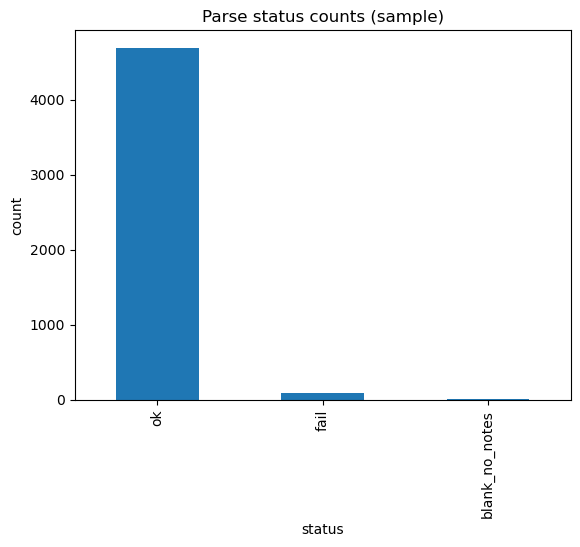

ok                97.75
fail               1.98
blank_no_notes     0.27
Name: status, dtype: float64


In [ ]:
import matplotlib.pyplot as plt

status_counts = rep["status"].value_counts()

plt.figure()
status_counts.plot(kind="bar")
plt.title("Parse status counts (sample)")
plt.xlabel("status")
plt.ylabel("count")
plt.show()

print((status_counts / len(rep) * 100).round(2))  #percentages


Top error types (what’s failing?)

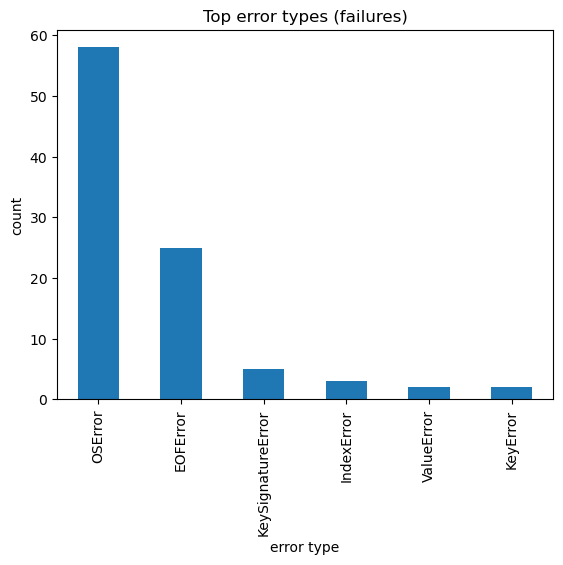

In [ ]:
fail_rep = rep[rep["status"] == "fail"].copy()
err_counts = fail_rep["err_type"].value_counts().head(15)

plt.figure()
err_counts.plot(kind="bar")
plt.title("Top error types (failures)")
plt.xlabel("error type")
plt.ylabel("count")
plt.show()


In [ ]:
err_table = fail_rep["err_type"].value_counts().reset_index()
err_table.columns = ["err_type", "count"]
err_table

,err_type,count
0,OSError,58
1,EOFError,25
2,KeySignatureError,5
3,IndexError,3
4,ValueError,2
5,KeyError,2


Do failures correlate with file size?

<Figure size 640x480 with 0 Axes>

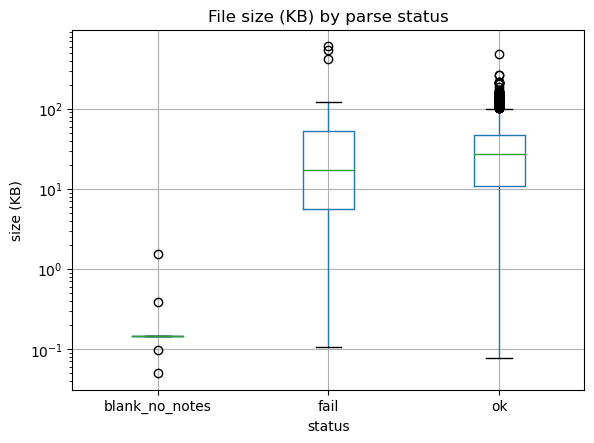

In [16]:
rep2 = rep.copy()
rep2["size_kb"] = rep2["size_bytes"] / 1024

plt.figure()
rep2.boxplot(column="size_kb", by="status")
plt.title("File size (KB) by parse status")
plt.suptitle("")  # remove automatic subtitle
plt.xlabel("status")
plt.ylabel("size (KB)")
plt.yscale("log")  # file sizes often heavy-tailed
plt.show()


Note count distribution

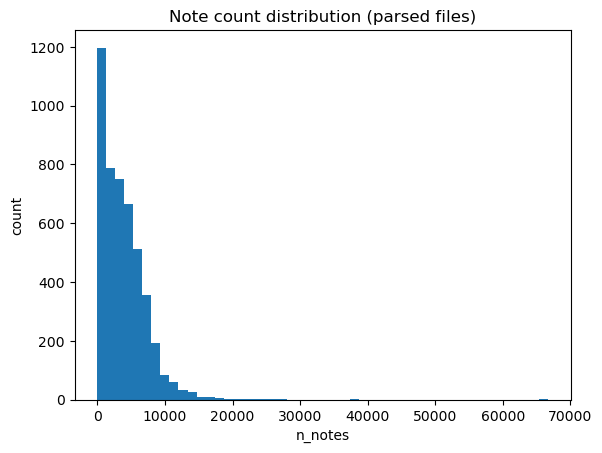

0.50     3300.00
0.90     7864.40
0.95     9462.00
0.99    14134.12
Name: n_notes, dtype: float64


In [17]:
ok_like = rep[rep["status"].isin(["ok", "blank_no_notes"])].copy()
ok_like["n_notes"] = pd.to_numeric(ok_like["n_notes"], errors="coerce").fillna(0)

plt.figure()
ok_like["n_notes"].plot(kind="hist", bins=50)
plt.title("Note count distribution (parsed files)")
plt.xlabel("n_notes")
plt.ylabel("count")
plt.show()

print(ok_like["n_notes"].quantile([0.5, 0.9, 0.95, 0.99]))

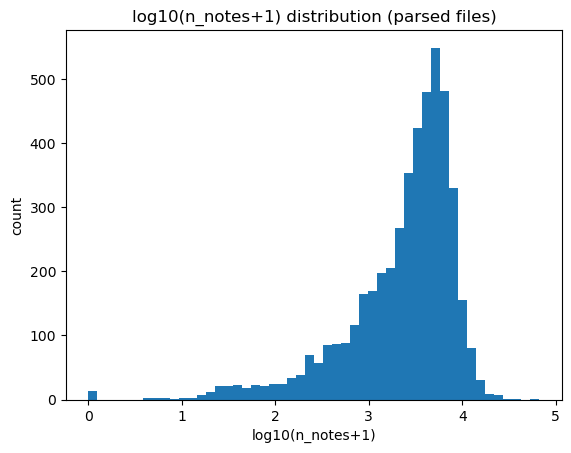

In [18]:
plt.figure()
(ok_like["n_notes"] + 1).apply(lambda x: __import__("math").log10(x)).plot(kind="hist", bins=50)
plt.title("log10(n_notes+1) distribution (parsed files)")
plt.xlabel("log10(n_notes+1)")
plt.ylabel("count")
plt.show()


Instruments per file

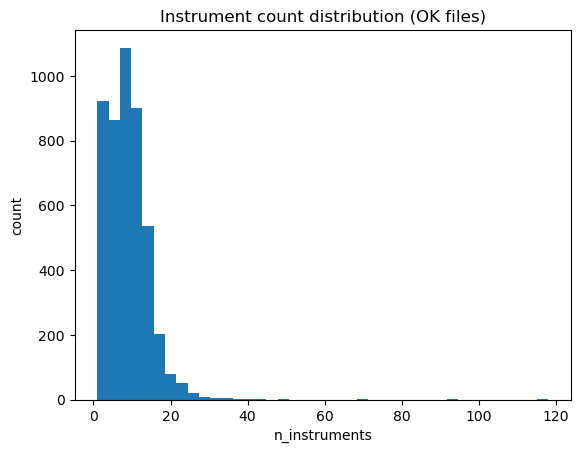

0.50     8.0
0.90    15.0
0.95    18.0
0.99    25.0
Name: n_instruments, dtype: float64


In [19]:
ok_ok = rep[rep["status"] == "ok"].copy()
ok_ok["n_instruments"] = pd.to_numeric(ok_ok["n_instruments"], errors="coerce")

plt.figure()
ok_ok["n_instruments"].plot(kind="hist", bins=40)
plt.title("Instrument count distribution (OK files)")
plt.xlabel("n_instruments")
plt.ylabel("count")
plt.show()

print(ok_ok["n_instruments"].quantile([0.5, 0.9, 0.95, 0.99]))

tempo changes per file

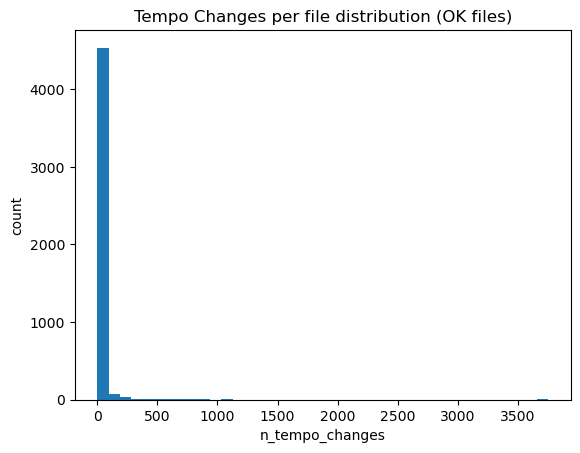

0.50      1.00
0.90     20.00
0.95     58.00
0.99    411.72
Name: n_tempo_changes, dtype: float64


In [20]:
ok_ok["n_tempo_changes"] = pd.to_numeric(ok_ok["n_tempo_changes"], errors="coerce").fillna(0)

plt.figure()
ok_ok["n_tempo_changes"].plot(kind="hist", bins=40)
plt.title("Tempo Changes per file distribution (OK files)")
plt.xlabel("n_tempo_changes")
plt.ylabel("count")
plt.show()

print(ok_ok["n_tempo_changes"].quantile([0.5, 0.9, 0.95, 0.99]))

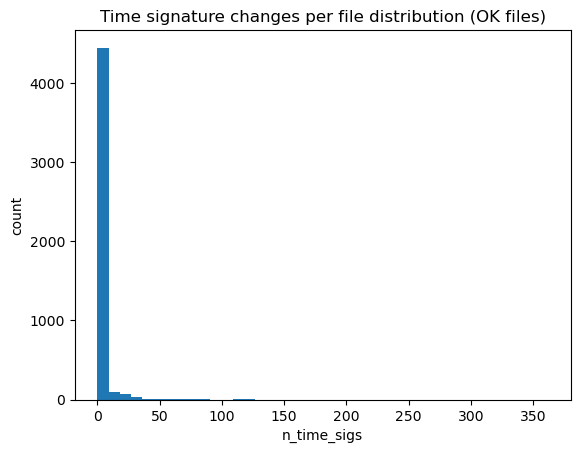

0.50     1.00
0.90     3.00
0.95    10.00
0.99    33.09
Name: n_time_sigs, dtype: float64


In [21]:
ok_ok["n_time_sigs"] = pd.to_numeric(ok_ok["n_time_sigs"], errors="coerce").fillna(0).astype(int)

plt.figure()
ok_ok["n_time_sigs"].plot(kind="hist", bins=40)
plt.title("Time signature changes per file distribution (OK files)")
plt.xlabel("n_time_sigs")
plt.ylabel("count")
plt.show()

print(ok_ok["n_time_sigs"].quantile([0.5, 0.9, 0.95, 0.99]))

Tempo Exploring 

In [24]:
import numpy as np
tempo_bins = np.geomspace(16, 256, 49)

def quantize_tempo(bpm: float) -> int:
    """Return index of nearest tempo bin."""
    bpm = float(np.clip(bpm, 16, 256))
    return int(np.argmin(np.abs(tempo_bins - bpm)))

In [25]:
from pathlib import Path
import pandas as pd
from miditoolkit import MidiFile

project_root = Path.home() / "fyp-musicgen"
raw_root = project_root / "data" / "raw" / "lmd_full"
manifest_path = project_root / "data" / "processed" / "manifests" / "lmd_full_manifest.csv"

df = pd.read_csv(manifest_path)
df = df[df["size_bytes"] > 0].copy()

SAMPLE_PER_PREFIX = 300   # total 3200
sample_df = (
    df.groupby("folder_prefix", group_keys=False)
      .apply(lambda g: g.sample(n=min(SAMPLE_PER_PREFIX, len(g)), random_state=42))
      .reset_index(drop=True)
)

rows = []

for _, r in sample_df.iterrows():
    rel = r["path"]
    p = raw_root / rel

    try:
        midi = MidiFile(str(p))
        tempos = [tc.tempo for tc in (midi.tempo_changes or [])]

        # If no tempo events, many tools assume 120 BPM
        if len(tempos) == 0:
            tempos = [120.0]

        rows.append({
            "path": rel,
            "folder_prefix": r["folder_prefix"],
            "n_tempo_changes_raw": len(midi.tempo_changes or []),
            "tempo_first": tempos[0],
            "tempo_median": float(np.median(tempos)),
            "tempo_mean": float(np.mean(tempos)),
            "tempo_min": float(np.min(tempos)),
            "tempo_max": float(np.max(tempos)),
            "tempo_median_bin": quantize_tempo(np.median(tempos)),
        })

    except Exception as e:
        # skip failed parses (we already know ~2% fail)
        continue

tempo_df = pd.DataFrame(rows)
tempo_df.head()

,path,folder_prefix,n_tempo_changes_raw,tempo_first,tempo_median,tempo_mean,tempo_min,tempo_max,tempo_median_bin
0,0/08b60e9e7f93b13fac4797ff7aa431f6.mid,0,2,120.000000,130.000070,130.000070,120.000000,140.000140,36
1,0/00bab5b74531f5872d152f2274ec8a5e.mid,0,1,100.000000,100.000000,100.000000,100.000000,100.000000,32
2,0/0e0b68089594301f710009568ea0574d.mid,0,1,145.000036,145.000036,145.000036,145.000036,145.000036,38
3,0/0c93a0d59b8fd09e68ce692f37eabe75.mid,0,1,73.999983,73.999983,73.999983,73.999983,73.999983,27
4,0/08017de5559f8d73c0071daf6cc81ffc.mid,0,3,100.000000,100.000000,83.333333,50.000000,100.000000,32


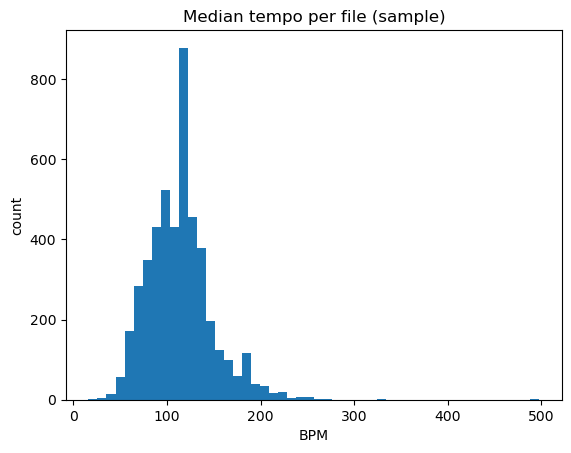

0.50    115.000029
0.90    157.000249
0.95    180.000180
0.99    215.960584
Name: tempo_median, dtype: float64


In [26]:
import matplotlib.pyplot as plt

plt.figure()
tempo_df["tempo_median"].plot(kind="hist", bins=50)
plt.title("Median tempo per file (sample)")
plt.xlabel("BPM")
plt.ylabel("count")
plt.show()

print(tempo_df["tempo_median"].quantile([0.5, 0.9, 0.95, 0.99]))

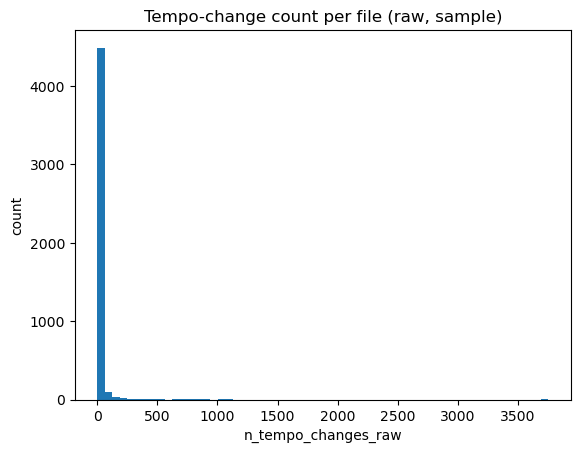

0.50      1.0
0.90     20.0
0.95     58.0
0.99    410.2
Name: n_tempo_changes_raw, dtype: float64


In [27]:
plt.figure()
tempo_df["n_tempo_changes_raw"].plot(kind="hist", bins=60)
plt.title("Tempo-change count per file (raw, sample)")
plt.xlabel("n_tempo_changes_raw")
plt.ylabel("count")
plt.show()

print(tempo_df["n_tempo_changes_raw"].quantile([0.5, 0.9, 0.95, 0.99]))

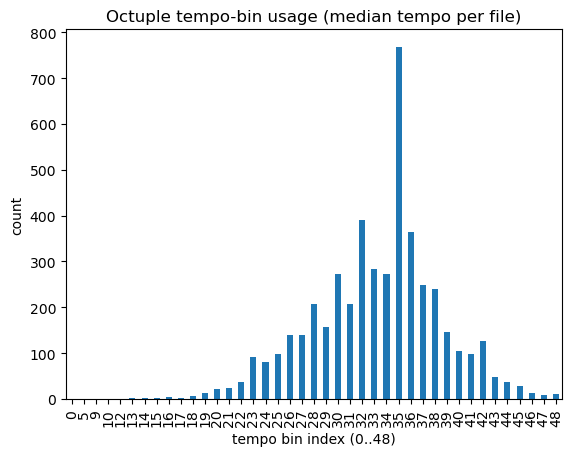

Unique bins used: 41 / 49


In [28]:
bin_counts = tempo_df["tempo_median_bin"].value_counts().sort_index()

plt.figure()
bin_counts.plot(kind="bar")
plt.title("Octuple tempo-bin usage (median tempo per file)")
plt.xlabel("tempo bin index (0..48)")
plt.ylabel("count")
plt.show()

print("Unique bins used:", bin_counts.shape[0], "/ 49")

In [29]:
def cleaned_tempo_bins(midi: MidiFile):
    tcs = midi.tempo_changes or []
    if len(tcs) == 0:
        return [quantize_tempo(120.0)]
    bins = []
    last = None
    for tc in tcs:
        b = quantize_tempo(tc.tempo)
        if b != last:
            bins.append(b)
            last = b
    return bins

clean_counts = []
for _, r in sample_df.iterrows():
    p = raw_root / r["path"]
    try:
        midi = MidiFile(str(p))
        clean_bins = cleaned_tempo_bins(midi)
        clean_counts.append({
            "path": r["path"],
            "n_tempo_bins_clean": len(clean_bins),
            "n_tempo_changes_raw": len(midi.tempo_changes or []),
        })
    except:
        pass

clean_df = pd.DataFrame(clean_counts)
clean_df["reduction_ratio"] = clean_df["n_tempo_bins_clean"] / (clean_df["n_tempo_changes_raw"].replace(0, np.nan))

print(clean_df[["n_tempo_changes_raw","n_tempo_bins_clean"]].quantile([0.5,0.9,0.95,0.99]))


      n_tempo_changes_raw  n_tempo_bins_clean
0.50                  1.0                 1.0
0.90                 20.0                10.0
0.95                 58.0                24.0
0.99                410.2               180.0


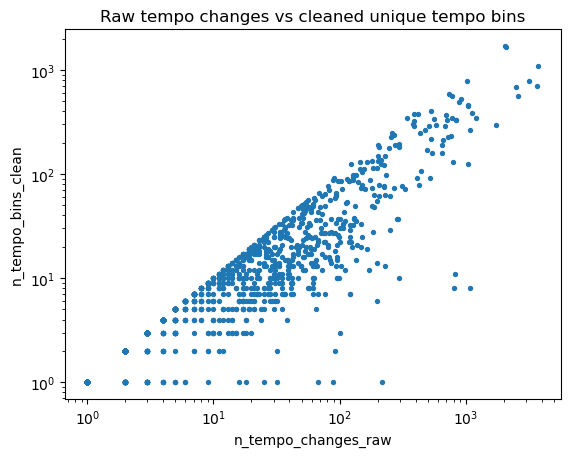

In [30]:
plt.figure()
plt.scatter(clean_df["n_tempo_changes_raw"], clean_df["n_tempo_bins_clean"], s=8)
plt.title("Raw tempo changes vs cleaned unique tempo bins")
plt.xlabel("n_tempo_changes_raw")
plt.ylabel("n_tempo_bins_clean")
plt.xscale("log")
plt.yscale("log")
plt.show()


Experiment

In [31]:
import numpy as np

# OctupleMIDI tempo bins: 49 values from 16 to 256 (geometric)
tempo_bins = np.geomspace(16, 256, 49)

def quantize_tempo_to_bin(bpm: float) -> int:
    bpm = float(np.clip(bpm, 16, 256))
    return int(np.argmin(np.abs(tempo_bins - bpm)))


In [32]:
from pathlib import Path
import pandas as pd

project_root = Path.home() / "fyp-musicgen"
raw_root = project_root / "data" / "raw" / "lmd_full"
report_path = project_root / "data" / "processed" / "reports" / "lmd_full_parse_healthcheck_sample.csv"

rep = pd.read_csv(report_path)

ok = rep[rep["status"] == "ok"].copy()
ok["n_tempo_changes"] = pd.to_numeric(ok["n_tempo_changes"], errors="coerce").fillna(0).astype(int)

# extreme tempo-change files
top_extreme = ok.sort_values("n_tempo_changes", ascending=False).head(2)

# normal files (choose from low tempo-change region)
normal_pool = ok[ok["n_tempo_changes"] <= 2].sample(2, random_state=42)

test_files = pd.concat([top_extreme, normal_pool], ignore_index=True)

test_files[["path", "n_tempo_changes"]]


,path,n_tempo_changes
0,3/3b307d78f862e57028bba694136cf866.mid,3751
1,1/1a1269ba8e9a0dd357eb6559c10654bd.mid,3699
2,d/d0cd85c3fe1b16fb236edccbe414c1e1.mid,1
3,1/14a1f5f9cfa501edec098d860a19d3e7.mid,1


In [33]:
from miditoolkit import MidiFile

def build_raw_tempo_events(midi: MidiFile):
    # list of (time_tick, tempo_bin)
    tcs = midi.tempo_changes or []
    if len(tcs) == 0:
        return [(0, quantize_tempo_to_bin(120.0))]
    ev = [(int(tc.time), quantize_tempo_to_bin(tc.tempo)) for tc in tcs]
    ev.sort(key=lambda x: x[0])
    # ensure first event starts at 0
    if ev[0][0] != 0:
        ev.insert(0, (0, ev[0][1]))
    return ev

def build_clean_tempo_events(midi: MidiFile):
    # quantization-aware cleaning:
    # keep only tempo events that change the BIN, drop consecutive duplicates
    raw = build_raw_tempo_events(midi)
    clean = []
    last_bin = None
    for t, b in raw:
        if b != last_bin:
            clean.append((t, b))
            last_bin = b
    return clean

def assign_tempo_bins_to_notes(midi: MidiFile, tempo_events):
    """
    For each note, find the most recent tempo event at or before note.start (tick),
    and assign that tempo_bin.
    """
    # Flatten notes with their start ticks
    notes = []
    for ins in midi.instruments:
        for n in ins.notes:
            notes.append(int(n.start))
    notes.sort()

    # Walk through tempo events once (two-pointer)
    assigned = []
    j = 0
    current_bin = tempo_events[0][1]

    for start_tick in notes:
        while j + 1 < len(tempo_events) and tempo_events[j + 1][0] <= start_tick:
            j += 1
            current_bin = tempo_events[j][1]
        assigned.append(current_bin)

    return assigned  # list aligned with sorted note starts


In [ ]:
results = []

for _, row in test_files.iterrows():
    rel_path = row["path"]
    midi_path = raw_root / rel_path

    midi = MidiFile(str(midi_path))

    raw_events = build_raw_tempo_events(midi)
    clean_events = build_clean_tempo_events(midi)

    raw_note_bins = assign_tempo_bins_to_notes(midi, raw_events)
    clean_note_bins = assign_tempo_bins_to_notes(midi, clean_events)

    # difference rate
    diffs = sum(a != b for a, b in zip(raw_note_bins, clean_note_bins))
    diff_rate = diffs / max(1, len(raw_note_bins))

    results.append({
        "path": rel_path,
        "raw_tempo_events": len(raw_events),
        "clean_tempo_events": len(clean_events),
        "reduction_factor": len(raw_events) / max(1, len(clean_events)),
        "n_notes_used": len(raw_note_bins),
        "note_bin_diff_rate": diff_rate
    })

pd.DataFrame(results)


,path,raw_tempo_events,clean_tempo_events,reduction_factor,n_notes_used,note_bin_diff_rate
0,3/3b307d78f862e57028bba694136cf866.mid,3751,1093,3.431839,6377,0.0
1,1/1a1269ba8e9a0dd357eb6559c10654bd.mid,3699,702,5.269231,7361,0.0
2,d/d0cd85c3fe1b16fb236edccbe414c1e1.mid,1,1,1.000000,986,0.0
3,1/14a1f5f9cfa501edec098d860a19d3e7.mid,1,1,1.000000,5676,0.0


### Priliminary Decisions